In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 特征筛选

In [4]:
# 制作数据集
path = '/home/chocolate/LSTM-source/Main_product_added_features/'
seq_new_25 = []

data = pd.read_csv(path + 'IF_main_cleaned_addfeature.csv')
data_new = data.drop(data.columns[35:],axis = 1)
data_new = data_new.ix[25:, 1:]
data_new = data_new[:-4]
data_new.index = range(len(data_new))


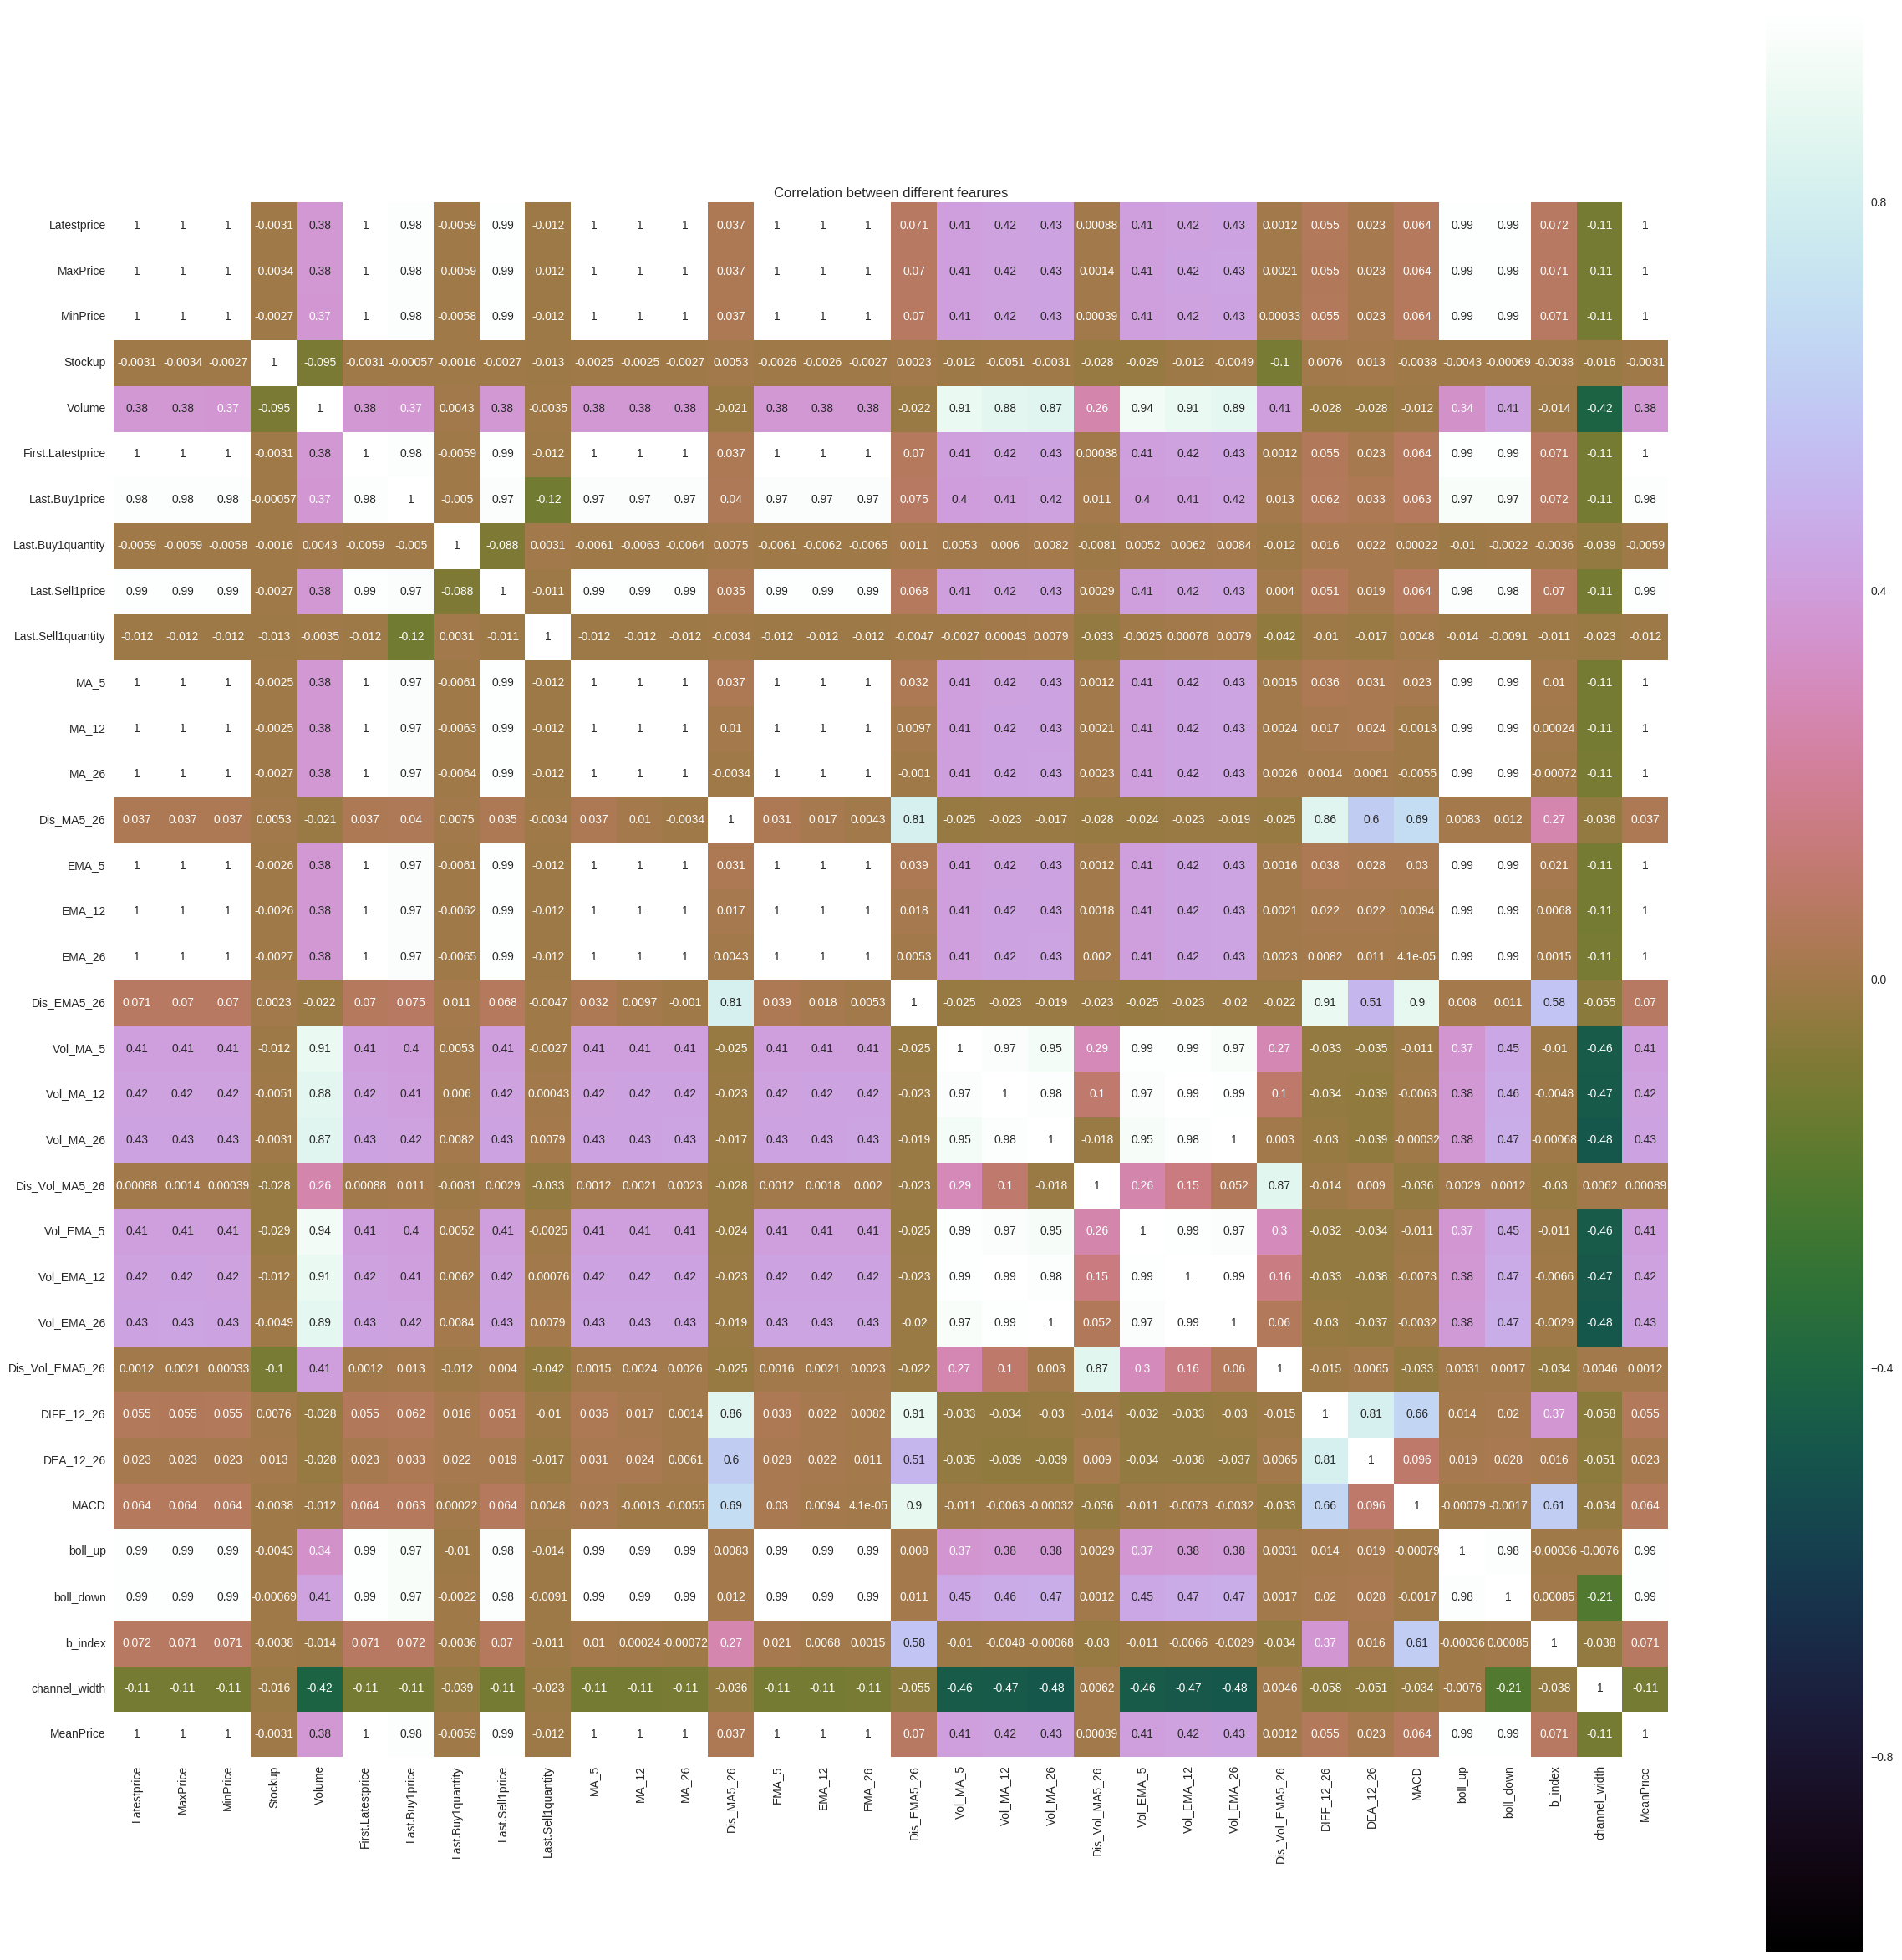

In [5]:
#   数据归一化
data_array_per = np.array(data_new)
min_max_scaler = preprocessing.MinMaxScaler()
data_array_per = min_max_scaler.fit_transform(data_array_per)

# 画相关系数图
correlation = data_new.corr()
plt.figure(figsize=(30,30))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')
    

In [6]:
eig_vals, eig_vecs = np.linalg.eig(correlation)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)



Eigenvectors 
[[  2.37155539e-01   1.01996860e-01  -1.01371607e-02 ...,   5.13983793e-02
   -2.00884128e-01   7.98703512e-04]
 [  2.37243970e-01   1.01336536e-01  -1.00893134e-02 ...,   5.14797463e-02
   -2.01202160e-01   7.99967734e-04]
 [  2.37070411e-01   1.02611185e-01  -1.03252702e-02 ...,   5.13154119e-02
   -2.00559881e-01   7.97414058e-04]
 ..., 
 [  8.66356000e-03   5.08008777e-02   2.69460052e-01 ...,  -3.84917709e-13
    1.20624430e-12  -4.46765124e-15]
 [ -5.58168811e-02   2.02798062e-01  -8.25247421e-02 ...,   1.91420507e-13
   -2.09682023e-12   8.02757148e-14]
 [  2.37157850e-01   1.01981328e-01  -1.01838368e-02 ...,  -1.54192814e-01
    6.02643332e-01  -2.39607418e-03]]

Eigenvalues 
[  1.67576894e+01   5.30016512e+00   4.01915707e+00   1.92506130e+00
   1.30867231e+00   1.02288744e+00   1.00538222e+00   9.83382816e-01
   7.22892571e-01   4.91492149e-01   2.14362792e-01   1.55464742e-01
   3.13480239e-02   2.83534806e-02   1.34347345e-02   1.02236644e-02
   5.35380709e-0

In [7]:


# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])



Eigenvalues in descending order:
16.757689416
5.30016511848
4.01915706977
1.92506129918
1.30867231046
1.02288744033
1.00538222359
0.983382816398
0.722892570692
0.491492148582
0.214362792253
0.155464741743
0.0313480239387
0.0283534805677
0.0134347344866
0.0102236644084
0.00535380709241
0.00210113732934
0.00171509981174
0.000342632657634
0.000254169526642
0.000202074288212
2.68132688958e-05
1.99530155544e-05
1.23228454634e-05
2.13932748575e-06
4.89457512155e-14
4.00644247936e-14
3.58662284079e-14
2.61175042591e-14
2.04957247182e-14
1.25021959887e-14
4.38262989242e-15
3.77048597664e-15


In [8]:
print data_array_per

[[ 0.01534356  0.01551797  0.01574277 ...,  0.40750334  0.03337546
   0.01552066]
 [ 0.01285706  0.0127902   0.01300754 ...,  0.24928982  0.0303956
   0.0128698 ]
 [ 0.01249318  0.0127902   0.01282519 ...,  0.27386946  0.03484396
   0.01268768]
 ..., 
 [ 0.42743647  0.42716858  0.42882324 ...,  0.60319762  0.13674913
   0.42796147]
 [ 0.41670204  0.41643935  0.41800389 ...,  0.47353058  0.1358794
   0.41719616]
 [ 0.42731518  0.42728981  0.42870168 ...,  0.59354441  0.12484028
   0.427921  ]]


In [9]:
mean_vec = np.mean(data_array_per, axis=0)
cov_mat = (data_array_per - mean_vec).T.dot((data_array_per - mean_vec)) / (data_array_per.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)



Covariance matrix 
[[ 0.04450055  0.0445489   0.04452817 ...,  0.00221723 -0.00384857
   0.04454389]
 [ 0.0445489   0.04459828  0.04457657 ...,  0.00221025 -0.00384914
   0.04459262]
 [ 0.04452817  0.04457657  0.04455675 ...,  0.00220804 -0.00385282
   0.04457186]
 ..., 
 [ 0.00221723  0.00221025  0.00220804 ...,  0.02156457 -0.00088622
   0.00221274]
 [-0.00384857 -0.00384914 -0.00385282 ..., -0.00088622  0.02582225
  -0.00385173]
 [ 0.04454389  0.04459262  0.04457186 ...,  0.00221274 -0.00385173
   0.0445875 ]]


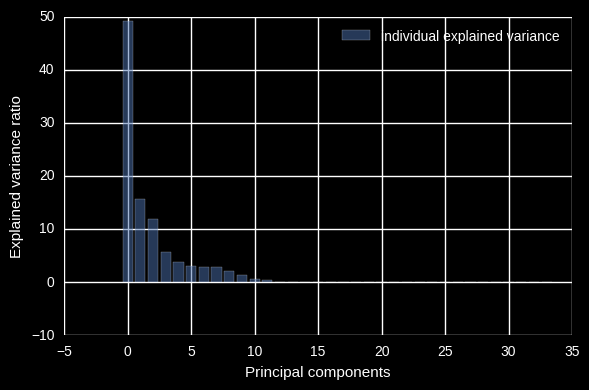

In [12]:


tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]



with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(34), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()



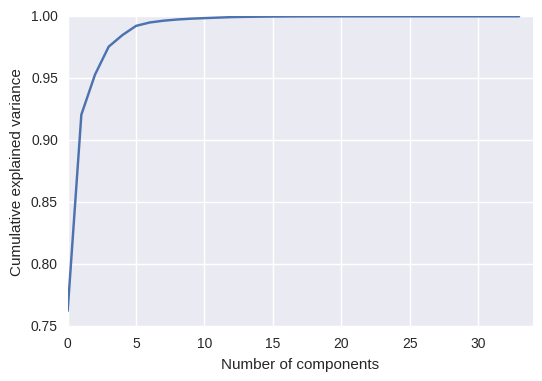

In [14]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_array_per)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,34,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

## 为验证后面添加的特征是否对测试准确率确实无影响，用下面的代码分别进行训练（切换34个特征和10个特征），观察准确率变化。同时，也验证了序列长度对测试准确率有无影响（切换10分钟序列和25分钟序列）。

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import datetime
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
import cPickle
import gzip
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
# 制作数据集
path = '/home/chocolate/LSTM-source/Main_product_added_features/'
seq_new_15 = []

data = pd.read_csv(path + 'IF_main_cleaned_addfeature.csv')
data_new = data.drop(data.columns[11:],axis = 1)
data_new = data_new.ix[25:, 1:]
data_new = data_new[:-5]
data_new.index = range(len(data_new))

In [3]:
data_new

,Latestprice,MaxPrice,MinPrice,Stockup,Volume,First.Latestprice,Last.Buy1price,Last.Buy1quantity,Last.Sell1price,Last.Sell1quantity
0,2156.2,2157.0,2156.0,259,1277,2156.8,2156.0000,212,2156.4,9
1,2148.0,2148.0,2147.0,-1,1414,2147.0,2147.8000,2,2148.4,2
2,2146.8,2148.0,2146.4,70,2287,2148.0,2146.6000,1,2147.0,8
3,2154.8,2156.0,2154.0,166,3771,2155.4,2154.8000,16,2155.0,88
4,2146.2,2146.6,2145.2,1,1986,2146.0,2146.0000,5,2146.2,2
5,2155.8,2155.8,2154.6,-17,1255,2155.2,2155.6000,10,2155.8,9
6,2171.0,2171.2,2170.2,0,1319,2170.2,2170.7999,2,2171.6,4
7,2170.8,2171.2,2170.8,1,1503,2171.0,2171.0000,1,2171.8,6
8,2155.6,2156.4,2155.0,2,1573,2155.0,2155.8000,2,2156.0,1
9,2146.8,2147.2,2146.4,9,977,2147.2,2146.4000,11,2147.0,4


In [28]:
#   数据归一化
data_array_per = np.array(data_new)
min_max_scaler = preprocessing.MinMaxScaler()
data_array_per = min_max_scaler.fit_transform(data_array_per)
#  组时间序列
for k in range(len(data_array_per)):
    if k < len(data_array_per) and k >= 15:
        seq_new_15.append(data_array_per[k - 15:k])
seq_new_15 = np.array(seq_new_15)
print seq_new_15.shape

(146384, 15, 10)


In [29]:
# 打数据集标签,根据归一化后的涨跌情况打标签。
#但是不同合约归一化后的涨跌幅分布仍然不同，所以必须按合约分别打标签。
seq_label = []

# print u'IF合约:'
data_IF = pd.read_csv(path + 'IF_main_cleaned_addfeature.csv')
data_per_new = data_IF[40:]
data_per_new = data_per_new[:-5]
 #   数据归一化
data_array_per = np.array(data_per_new)
min_max_scaler = preprocessing.MinMaxScaler()
data_array_per = min_max_scaler.fit_transform(data_array_per)
#     print data_array_per
data_per = pd.DataFrame(data_array_per,columns = data_per_new.columns)
# print data_per['RaiseDown_1'].describe()
    
for i in data_per['RaiseDown_1']:
    if i > 0.68:
        seq_label.append([1,0,0,0,0,0,0])   #大涨
    elif i > 0.58:
        seq_label.append([0,1,0,0,0,0,0])   #小涨
    elif i> 0.48: 
        seq_label.append([0,0,1,0,0,0,0])   #平稳
    elif i > 0.44:
        seq_label.append([0,0,0,1,0,0,0])   #小跌
    elif i > 0.34:
        seq_label.append([0,0,0,0,1,0,0])   #大跌
    elif i > 0.24:
        seq_label.append([0,0,0,0,0,1,0])   #大跌
    else:
        seq_label.append([0,0,0,0,0,0,1])   #大跌

print u'涨幅3：',seq_label.count([1,0,0,0,0,0,0]),seq_label.count([1,0,0,0,0,0,0]) /146419.0
print u'涨幅2：',seq_label.count([0,1,0,0,0,0,0]),seq_label.count([0,1,0,0,0,0,0]) /146419.0
print u'涨幅1：',seq_label.count([0,0,1,0,0,0,0]),seq_label.count([0,0,1,0,0,0,0]) /146419.0
print u'平 稳：',seq_label.count([0,0,0,1,0,0,0]),seq_label.count([0,0,0,1,0,0,0]) /146419.0
print u'跌幅1：',seq_label.count([0,0,0,0,1,0,0]),seq_label.count([0,0,0,0,1,0,0]) /146419.0
print u'跌幅2：',seq_label.count([0,0,0,0,0,1,0]),seq_label.count([0,0,0,0,0,1,0]) /146419.0
print u'跌幅3：',seq_label.count([0,0,0,0,0,0,1]),seq_label.count([0,0,0,0,0,0,1]) /146419.0


涨幅3： 3451 0.0235693455084
涨幅2： 8535 0.0582916151592
涨幅1： 31366 0.214220831996
平 稳： 61387 0.41925569769
跌幅1： 30792 0.210300575745
跌幅2： 8125 0.0554914321229
跌幅3： 2728 0.0186314617638


In [30]:
arr_label=np.array(seq_label)
arr_label.shape

(146384, 7)

In [31]:
from random import shuffle
zip_seq = zip(seq_new_15,seq_label)
shuffle(zip_seq)
seq_new_15,seq_label = zip(*zip_seq)
seq_new_15 = np.array(seq_new_15) 
seq_label = np.array(seq_label)
print seq_new_15.shape, seq_label.shape

(146384, 15, 10) (146384, 7)


In [36]:
train_data = seq_new_15[:102500]
train_label = seq_label[:102500]

test_data = seq_new_15[102500:]
test_label = seq_label[102500:]
train_data.shape, test_label.shape

((102500, 15, 10), (43884, 7))

In [37]:
# 保存训练集和测试集
path_new = '/home/chocolate/LSTM-source/train_test_data/'
f1 = file(path_new + 'train_data.npy','wb')
np.save(f1,train_data)
f1.close()
f2 = file(path_new + 'test_data.npy','wb')
np.save(f2,test_data)
f2.close()
f3 = file(path_new + 'train_label.npy','wb')
np.save(f3,train_label)
f3.close()
f4 = file(path_new + 'test_label.npy','wb')
np.save(f4,test_label)
f4.close()

## 每次运行从此处开始

In [38]:
path_new = '/home/chocolate/LSTM-source/train_test_data/'
# 读取训练集和测试集
f1 = file(path_new + 'train_data.npy','rb')
train_data = np.load(f1)
f2 = file(path_new + 'test_data.npy','rb')
test_data = np.load(f2)
f3 = file(path_new + 'train_label.npy','rb')
train_label = np.load(f3)
f4 = file(path_new + 'test_label.npy','rb')
test_label = np.load(f4)

In [42]:
train_data.shape

(102500, 15, 10)

In [24]:
import random

learning_rate = 0.001 # 学习速率
training_iters = 500000  # 训练总步长
batch_size = 250 # 每小段步长
display_step = 10  # 每隔100小段显示输出

# 参数设置
n_input = 10 # 特征数量
n_steps = 15 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 7 # 分类数量
num_layers = 3 #隐藏层数量
keep_prob = 0.8 

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])

# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# def pred():
    
def RNN(x, weights, biases):

    # 更改数据集的格式，使其满足RNN网络的输入需求
    # 现在输入格式: (batch_size, n_steps, n_input)
    # 需要的格式: 'n_steps' 个tensor，每个的格式为 (batch_size, n_input)

    # 变换batch_size 和 n_steps的位置
    x = tf.transpose(x, [1, 0, 2])
    # 重新调整格式 (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # 分割成一系列的 'n_steps' 个tensors，每个的格式为 (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # 定义LSTM神经网络结构
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    if keep_prob < 1: # 在外面包裹一层dropout
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers)
    # 获取输出和状态
    outputs, states = rnn.rnn(cell, x, dtype=tf.float32)
    # 返回输出
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
# 获取预测值
pred = RNN(xtr, weights, biases)
# train_label = tf.split(0, batch_size, train_label)
# 取下一小段的输入
def next_batch_tr(batch_size):
    step = random.randint(1, len(train_data)/batch_size)
    next_batch_data = train_data[(step-1)*batch_size:step*batch_size]
    next_batch_label = train_label[(step-1)*batch_size:step*batch_size]   
    return next_batch_data, next_batch_label



In [25]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 变量初始化
init = tf.initialize_all_variables()
part_saver = tf.train.Saver()
# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
# pred1 = sess.run(pred, feed_dict={xtr: seq_data})
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(batch_size)
    batch_x = batch_x.reshape((-1, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

saver_path = part_saver.save(sess, "/home/chocolate/LSTM-source/models/predict_1min.ckpt")
print "Model saved." 


Iter 2500, Minibatch Loss= 1.792330, Training Accuracy= 0.32000
Iter 5000, Minibatch Loss= 1.555333, Training Accuracy= 0.41600
Iter 7500, Minibatch Loss= 1.452552, Training Accuracy= 0.38000
Iter 10000, Minibatch Loss= 1.396169, Training Accuracy= 0.45200
Iter 12500, Minibatch Loss= 1.450089, Training Accuracy= 0.37600
Iter 15000, Minibatch Loss= 1.403651, Training Accuracy= 0.39200
Iter 17500, Minibatch Loss= 1.411313, Training Accuracy= 0.43600
Iter 20000, Minibatch Loss= 1.398648, Training Accuracy= 0.42000
Iter 22500, Minibatch Loss= 1.436758, Training Accuracy= 0.39200
Iter 25000, Minibatch Loss= 1.528171, Training Accuracy= 0.34000
Iter 27500, Minibatch Loss= 1.413145, Training Accuracy= 0.44000
Iter 30000, Minibatch Loss= 1.385383, Training Accuracy= 0.40000
Iter 32500, Minibatch Loss= 1.443903, Training Accuracy= 0.40000
Iter 35000, Minibatch Loss= 1.420163, Training Accuracy= 0.38400
Iter 37500, Minibatch Loss= 1.432701, Training Accuracy= 0.43200
Iter 40000, Minibatch Loss= 

## 尝试修改网络结构，使用双向循环神经网络

In [18]:
import random

learning_rate = 0.001 # 学习速率
training_iters = 500000  # 训练总步长
batch_size = 2500 # 每小段步长
display_step = 10  # 每隔10小段显示输出

# 参数设置
n_input = 10 # 特征数量
n_steps = 25 # 时间序列长度
n_hidden = 500 # 隐藏层神经元个数
n_classes = 7 # 分类数量

tf.reset_default_graph()  # 重置流图
# 设置输入输出格式大小
xtr = tf.placeholder("float", [None, n_steps, n_input])
ytr = tf.placeholder("float", [None,n_classes])

# 定义权重和偏移量
weights = {
    'out': tf.Variable(tf.random_normal([2 * n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}
def BiRNN(x, weights, biases):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshape to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Backward direction cell
    lstm_bw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = BiRNN(xtr, weights, biases)
def next_batch_tr(batch_size):
    step = random.randint(1, len(train_data)/batch_size)
    next_batch_data = train_data[(step-1)*batch_size:step*batch_size]
    next_batch_label = train_label[(step-1)*batch_size:step*batch_size]   
    return next_batch_data, next_batch_label


In [19]:
# 定义代价函数和最优化方法
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, ytr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 评估模型准确率
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(ytr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 变量初始化
init = tf.initialize_all_variables()
part_saver = tf.train.Saver()
# 创建会话
sess = tf.InteractiveSession()
sess.run(init)
step = 1
    # 一直迭代，直到最大步长
while step * batch_size < training_iters:
    batch_x, batch_y = next_batch_tr(batch_size)
    batch_x = batch_x.reshape((-1, n_steps, n_input))
        # 利用最优化方法调整权值
    sess.run(optimizer, feed_dict={xtr: batch_x, ytr: batch_y})
    if step % display_step == 0:
            # 计算准确率和损失函数
        acc = sess.run(accuracy, feed_dict={xtr: batch_x, ytr: batch_y})
        loss = sess.run(cost, feed_dict={xtr: batch_x, ytr: batch_y})
        # 每隔一定步长显示训练准确率和损失率
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
                "{:.6f}".format(loss) + ", Training Accuracy= " +
                "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

saver_path = part_saver.save(sess, "/home/chocolate/LSTM-source/models/predict_1min.ckpt")
print "Model saved." 


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f538ccab8d0>> ignored


Iter 25000, Minibatch Loss= 1.777927, Training Accuracy= 0.43800
Iter 50000, Minibatch Loss= 1.524802, Training Accuracy= 0.37720
Iter 75000, Minibatch Loss= 1.434372, Training Accuracy= 0.41320
Iter 100000, Minibatch Loss= 1.433727, Training Accuracy= 0.41400
Iter 125000, Minibatch Loss= 1.398171, Training Accuracy= 0.42240
Iter 150000, Minibatch Loss= 1.405053, Training Accuracy= 0.41720
Iter 175000, Minibatch Loss= 1.393256, Training Accuracy= 0.42840
Iter 200000, Minibatch Loss= 1.394247, Training Accuracy= 0.41040
Iter 225000, Minibatch Loss= 1.388863, Training Accuracy= 0.42920
Iter 250000, Minibatch Loss= 1.402678, Training Accuracy= 0.41320
Iter 275000, Minibatch Loss= 1.411972, Training Accuracy= 0.40560
Iter 300000, Minibatch Loss= 1.404181, Training Accuracy= 0.41440
Iter 325000, Minibatch Loss= 1.395193, Training Accuracy= 0.43320
Iter 350000, Minibatch Loss= 1.397049, Training Accuracy= 0.42360
Iter 375000, Minibatch Loss= 1.381194, Training Accuracy= 0.42680
Iter 400000, 

In [26]:
saver = tf.train.Saver()
saver.restore(sess, "/home/chocolate/LSTM-source/models/predict_1min.ckpt")
print "Model restored."
test_data1 = test_data.reshape((-1, n_steps, n_input))
# test_label1 = test_label[:test_len]
print("Testing Accuracy:",
        sess.run(accuracy, feed_dict={xtr: test_data1, ytr: test_label}))


Model restored.
('Testing Accuracy:', 0.41051409)


### 结论：增加特征、加长序列长度，都没有使准确率明显增加。换做双向循环网络后准确率也基本不变。因此还应从修改网络结构入手。